In [1]:
pip install pulp


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pulp

# Instantiate the problem class
model = pulp.LpProblem("Cost_minimizing_blending_problem", pulp.LpMinimize)

# Create decision variables
cookie_types = ['low-fat', 'regular']
ingredients = ['peanut butter', 'eggs', 'sugar']

# Decision variables with dictionary comprehension
ing_weight = pulp.LpVariable.dicts("weight_lbs",
                                   ((i, j) for i in cookie_types for j in ingredients),
                                   lowBound=0, cat='Continuous')

# Objective function
model += pulp.lpSum([4.32 * ing_weight[(i, 'peanut butter')] +
                     2.46 * ing_weight[(i, 'eggs')] +
                     1.86 * ing_weight[(i, 'sugar')]
                     for i in cookie_types])

# Constraints
# Total weight of ingredients in low-fat and regular cookies
model += pulp.lpSum([ing_weight['low-fat', j] for j in ingredients]) == 350 * 0.05
model += pulp.lpSum([ing_weight['regular', j] for j in ingredients]) == 500 * 0.05

# Peanut butter percentage constraints
model += ing_weight['low-fat', 'peanut butter'] >= 0.4 * pulp.lpSum([ing_weight['low-fat', j] for j in ingredients])
model += ing_weight['regular', 'peanut butter'] >= 0.6 * pulp.lpSum([ing_weight['regular', j] for j in ingredients])

# Sugar percentage constraints
model += ing_weight['low-fat', 'sugar'] <= 0.25 * pulp.lpSum([ing_weight['low-fat', j] for j in ingredients])
model += ing_weight['regular', 'sugar'] <= 0.25 * pulp.lpSum([ing_weight['regular', j] for j in ingredients])

# Ingredient availability constraints
model += pulp.lpSum([ing_weight[i, 'peanut butter'] for i in cookie_types]) <= 30
model += pulp.lpSum([ing_weight[i, 'eggs'] for i in cookie_types]) <= 20
model += pulp.lpSum([ing_weight[i, 'sugar'] for i in cookie_types]) <= 17

# Minimum peanut butter usage constraint
model += pulp.lpSum([ing_weight[i, 'peanut butter'] for i in cookie_types]) >= 23

# Solve the problem
model.solve()

# Print the results
print("Model Status: ", pulp.LpStatus[model.status])

for var in ing_weight:
    print(f"The weight of {var[1]} in {var[0]} cookies is {ing_weight[var].varValue} lbs")

total_cost = pulp.value(model.objective)
print(f"The total cost is ${round(total_cost, 2)} for 350 low-fat cookies and 500 regular cookies")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jackgorsuch/anaconda3/envs/autogen/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/j4/4cl44d592j7_ty0b8x3f01_h0000gn/T/5b186de04f064b43ab50b8e6c1b780dc-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/j4/4cl44d592j7_ty0b8x3f01_h0000gn/T/5b186de04f064b43ab50b8e6c1b780dc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 48 RHS
At line 59 BOUNDS
At line 60 ENDATA
Problem MODEL has 10 rows, 6 columns and 26 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 10 (0) rows, 6 (0) columns and 26 (0) elements
0  Obj 0 Primal inf 65.5 (3)
6  Obj 140.955
Optimal - objective value 140.955
Optimal objective 140.955 - 6 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds)

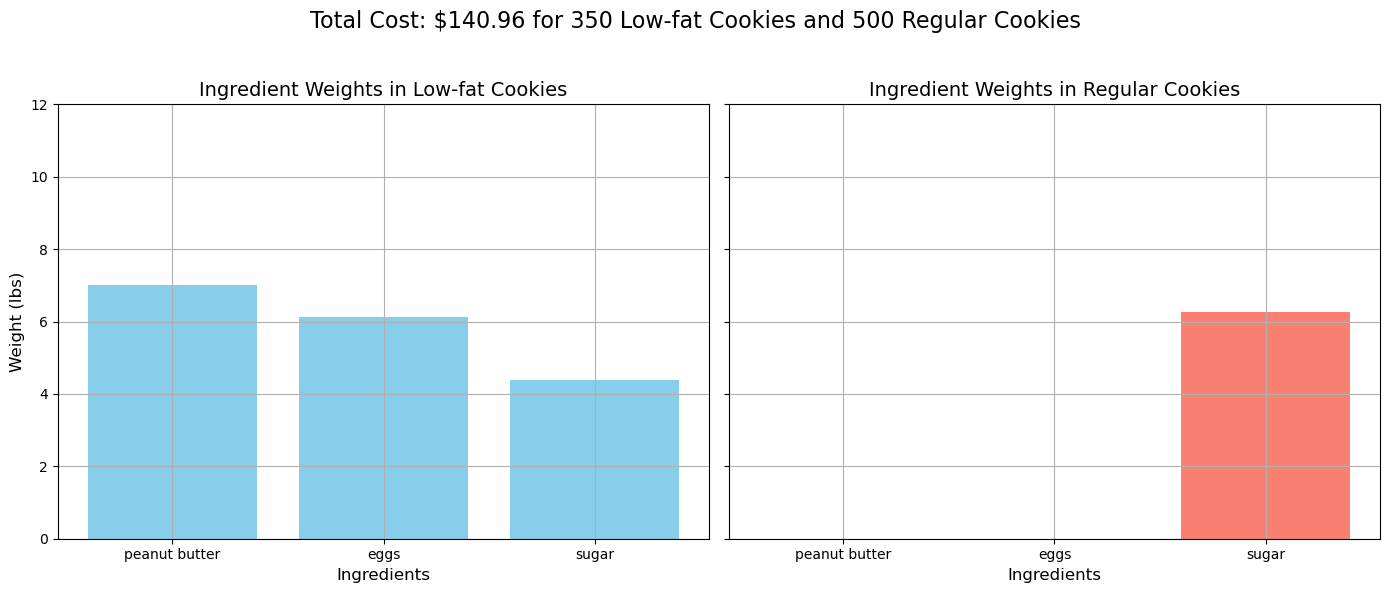

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Extracting results into a DataFrame
results = {'Ingredient': [], 'Low-fat Cookies (lbs)': [], 'Regular Cookies (lbs)': []}

for var in ing_weight:
    cookie_type, ingredient = var
    weight = ing_weight[var].varValue
    if ingredient not in results['Ingredient']:
        results['Ingredient'].append(ingredient)
        results['Low-fat Cookies (lbs)'].append(0)
        results['Regular Cookies (lbs)'].append(0)
    if cookie_type == 'low-fat':
        results['Low-fat Cookies (lbs)'][-1] = weight
    elif cookie_type == 'regular':
        results['Regular Cookies (lbs)'][-1] = weight

results_df = pd.DataFrame(results)

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Bar plot for Low-fat Cookies
ax[0].bar(results_df['Ingredient'], results_df['Low-fat Cookies (lbs)'], color='skyblue')
ax[0].set_title('Ingredient Weights in Low-fat Cookies', fontsize=14)
ax[0].set_xlabel('Ingredients', fontsize=12)
ax[0].set_ylabel('Weight (lbs)', fontsize=12)
ax[0].set_ylim(0, max(results_df['Low-fat Cookies (lbs)'].max(), results_df['Regular Cookies (lbs)'].max()) + 5)
ax[0].grid(True)

# Bar plot for Regular Cookies
ax[1].bar(results_df['Ingredient'], results_df['Regular Cookies (lbs)'], color='salmon')
ax[1].set_title('Ingredient Weights in Regular Cookies', fontsize=14)
ax[1].set_xlabel('Ingredients', fontsize=12)
ax[1].grid(True)

# Display total cost
fig.suptitle(f'Total Cost: ${round(total_cost, 2)} for 350 Low-fat Cookies and 500 Regular Cookies', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure in the current directory
plt.savefig('ingredient_weights.png')
plt.show()
